# KRYCY lab 1c
## Wykrywanie anomalii


In [9]:
import pandas as pd
from scapy.all import *
from scapy.layers.inet import IP, TCP

### Wczytanie danych - plik pcap
Przechodzimy po wszystkich pakietach:

In [10]:
scapy_cap = rdpcap('test_dir/trick_bot.pcap')
packet_tab = []
for packet in scapy_cap:
    if TCP in packet:
        ip_src = ""
        ip_dst = ""
        if IP in packet:
            ip_src=packet[IP].src
            ip_dst=packet[IP].dst

        tcp_time=packet[TCP].time
        tcp_sport=packet[TCP].sport
        tcp_dport=packet[TCP].dport
        packet_tab.append([str(tcp_time),tcp_sport,tcp_dport, ip_src, ip_dst])

### Preprocessing danych
#### Stworzenie DataFrame z pandasa

In [11]:
df = pd.DataFrame(packet_tab, columns=['time','src_port', 'dst_port', 'ip_src', 'ip_dst'])

### Mechanizm naliczania metryki
#### Zliczenie ruchu na każdym z wystepujących portów

In [12]:
connections = df.groupby(["dst_port"]).size().rename("amount").reset_index()
connections.columns = ['port', 'amount']
connections
connections2 = df.groupby(["src_port"]).size().rename("amount").reset_index()
connections2.columns = ['port', 'amount']
connections2
ports_traffic = pd.concat([connections, connections2]).groupby('port').sum().reset_index()
ports_traffic

,port,amount
0,80,1598
1,443,349
2,445,4
3,447,12228
4,448,30
...,...,...
149,49568,19
150,49569,23
151,49570,19
152,49571,19


### Ustalenie progu detekcji przekroczenia
#### Wyfiltrowanie portów z ruchem większym niż 100 pakietów i posortowanie malejąco

In [14]:
ports_traffic = ports_traffic[ports_traffic.amount>100]
ports_traffic.sort_values('amount', ascending=False)
ports_traffic

,port,amount
0,80,1598
1,443,349
3,447,12228
5,449,1713
15,49165,703
34,49184,256
37,49187,1889
38,49188,129
45,49195,925
47,49197,534


#### Wyfiltrowanie portów z grupy najpopularniejszych

In [15]:
ports_traffic = ports_traffic[ports_traffic.port<1024]
ports_traffic

,port,amount
0,80,1598
1,443,349
3,447,12228
5,449,1713


Wykres liczby pakietów od portu

<AxesSubplot:xlabel='port'>

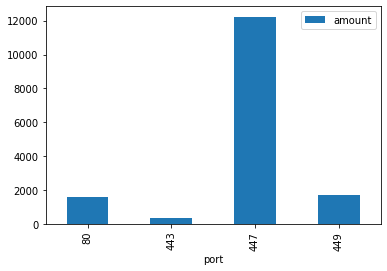

In [16]:
ports_traffic.plot.bar(x='port')

Połączenia na portach 80 i 443 są traktowane jako bezpieczne. Natomiast obawę może wzbudzać ilość połączeń na pozostałych portach

In [17]:
trusted_ports = [80, 443]
untrusted_ports = ports_traffic[~ports_traffic.port.isin(trusted_ports)]
if len(untrusted_ports) > 0:
    print('alert')

alert
